In [4]:
# Import Library
from google.colab import files
import zipfile
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [5]:
# 1. Unggah dan ekstrak dataset ZIP
uploaded = files.upload()

Saving aksaraJawa.zip to aksaraJawa (2).zip


In [28]:
zip_path = "aksaraJawa.zip"
dataset_path = "/dataset/aksaraJawa/dataset/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

print("Isi folder dataset:", os.listdir(dataset_path))

Isi folder dataset: ['dha', 'pa', 'ba', 'ka', 'tha', 'ha', 'Our Team.txt', 'ga', 'ra', 'dataset', 'da', 'ca', 'ta', 'na', 'la', 'sa', 'ya', 'ma', 'nya', 'ja', 'wa', 'nga']


In [29]:
for path, label in zip(image_files[:5], labels[:5]):
    print(f"Path: {path}, Label: {label}")


Path: /dataset/aksaraJawa/dataset/dataset/dha/90c40d9a-0fa6-4add-9a7f-e6674521914c.jpg, Label: dataset
Path: /dataset/aksaraJawa/dataset/dataset/dha/451b0c19-9e62-4687-b6ed-c0a251b6aae3.jpg, Label: dataset
Path: /dataset/aksaraJawa/dataset/dataset/dha/e6a8bcf5-abd5-442b-b200-e6f41c7e4307.jpg, Label: dataset
Path: /dataset/aksaraJawa/dataset/dataset/dha/2f2a5c0a-4cb9-4bbb-af5e-679dcc8f932b.jpg, Label: dataset
Path: /dataset/aksaraJawa/dataset/dataset/dha/1a9128de-3abd-40f7-9c9d-504f2b934296.jpg, Label: dataset


In [33]:
import glob
# 2. Membaca semua gambar dan label dari subfolder
IMAGE_SIZE = (224, 224)  # Ukuran gambar untuk model
image_files = []
labels = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith((".jpg", ".png", ".jpeg", ".png")):
            img_path = os.path.join(root, file)
            label = os.path.basename(root)  # nama folder tempat gambar berada
            image_files.append(img_path)
            labels.append(label)


In [34]:
# 3. Konversi gambar ke array numerik dan resize
image_data = []
for img_path in image_files:
    img = Image.open(img_path).resize(IMAGE_SIZE).convert("RGB")
    image_data.append(np.array(img))

# Normalisasi gambar ke rentang 0-1
X = np.array(image_data, dtype="float32") / 255.0
y = np.array(labels)

In [35]:
# 4. Encode Label Menjadi Angka
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print(f"Total Kelas: {len(np.unique(y_encoded))}")
print(f"Contoh Label: {encoder.classes_}")

Total Kelas: 20
Contoh Label: ['ba' 'ca' 'da' 'dha' 'ga' 'ha' 'ja' 'ka' 'la' 'ma' 'na' 'nga' 'nya' 'pa'
 'ra' 'sa' 'ta' 'tha' 'wa' 'ya']


In [36]:
# 5. Split Dataset: Train, Validation, dan Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Train set: (800, 224, 224, 3), Validation set: (100, 224, 224, 3), Test set: (100, 224, 224, 3)


In [37]:
# 6. Membuat TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [38]:
# 7. Transfer Learning Menggunakan MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Membekukan backbone agar tidak dilatih ulang

In [39]:
# Menambahkan lapisan fully connected
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Menggabungkan fitur dari backbone
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_encoded)), activation='softmax')  # Output sesuai jumlah kelas
])

# 8. Compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 9. Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 10. Train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[reduce_lr, early_stop]
)

# 11. Evaluasi model pada test set
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Prediksi pada test set
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Mengambil kelas dengan probabilitas tertinggi
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Label sebenarnya

# Hitung Precision, Recall, dan F1-Score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.0532 - loss: 3.3593 - val_accuracy: 0.1700 - val_loss: 2.8664 - learning_rate: 1.0000e-04
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.1271 - loss: 2.9125 - val_accuracy: 0.2700 - val_loss: 2.6815 - learning_rate: 1.0000e-04
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1990 - loss: 2.7047 - val_accuracy: 0.3900 - val_loss: 2.5082 - learning_rate: 1.0000e-04
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2855 - loss: 2.5109 - val_accuracy: 0.4700 - val_loss: 2.3705 - learning_rate: 1.0000e-04
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3684 - loss: 2.2606 - val_accuracy: 0.5000 - val_loss: 2.2191 - learning_rate: 1.0000e-04
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.3957 - loss: 2.1837 - val_accuracy: 0.4900 - val_loss: 2.1049 - learning_rate: 1.0000e-04
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4712 - loss:

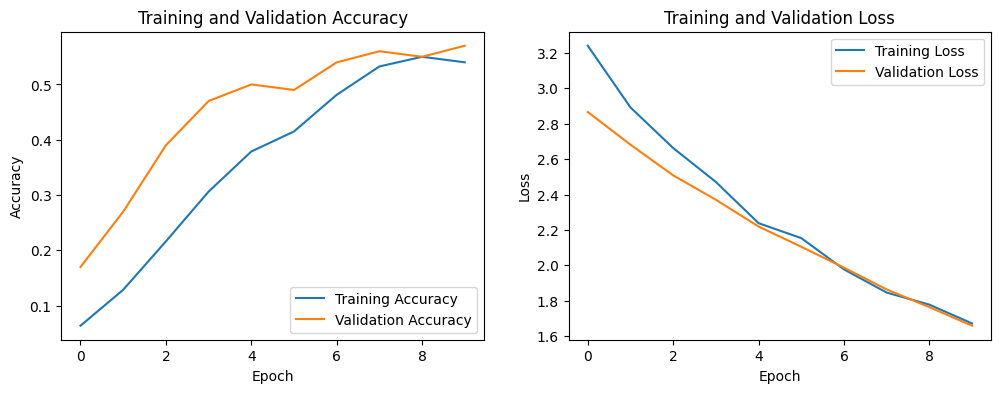

In [40]:
# 12. Visualisasi hasil training
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [41]:
# Simpan model ke format HDF5
model.save('model_aksara_lampung_mobilenetv2_cnn.h5')

In [42]:
model.save('model_aksara_lampung_mobilenetv2_cnn.keras')